In [2]:
import pandas as pd
import numpy as np
import itertools
import sklearn.model_selection
from collections import defaultdict

# display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# custom helper functions
%load_ext autoreload
%autoreload 2
from helper.general_helper import *

# surprise imorts
from surprise import Reader, Dataset
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD, NormalPredictor, SlopeOne, CoClustering, NMF
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.prediction_algorithms.baseline_only import BaselineOnly


# view plotly in jupyter 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
df = pd.read_csv('../../merged_df.csv')

df = df[df['title'].notna()]

# select reviewer and product values
customers = df['reviewerID'].value_counts()
products = df['asin'].value_counts()

# filter by 10 reviews per product per customer, products with 20 or more reviews
customers = customers[customers >= 10]
products = products[products >= 20]

# merge dataframe
df = df.merge(pd.DataFrame({'reviewerID': customers.index})).merge(pd.DataFrame({'asin': products.index}))


# shuffle dataframe
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

df = df[['reviewerID', 'asin', 'overall']]


In [6]:
# load into correct format
reader = Reader(rating_scale=(1, 5))

# create testing data and holdout data into surprise formatting
data = Dataset.load_from_df(df, reader)

#### model selection and testing

In [7]:
# check general untuned performance
benchmark = []
for model in [SVD(), NormalPredictor(), SlopeOne(), CoClustering(), NMF()]:
    cv_score = cross_validate(model, data, measures=['RMSE'], cv=3, verbose=False)
    
    tmp = pd.DataFrame.from_dict(cv_score).mean(axis=0)
    tmp = tmp.append(pd.Series([str(model).split(' ')[0].split('.')[-1]], index=['Model']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Model').sort_values('test_rmse')  

,test_rmse,fit_time,test_time
Model,,,
SVD,0.951335,3.863344,0.237908
CoClustering,1.010012,2.729985,0.240903
SlopeOne,1.062582,0.542593,0.701739
NMF,1.090333,4.881558,0.219475
NormalPredictor,1.361589,0.116777,0.230014


In [9]:
param_grid = {'n_epochs': [5, 10, 40, 80], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}

In [13]:
# SVD looks like the winner, lets tune the model and see how we can do
param_grid = {'n_factors':[10, 30, 80], 'n_epochs': [5, 10, 40, 80], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}

# set grid_search
gs_model = GridSearchCV(
    algo_class = SVD,
    param_grid = param_grid,
    n_jobs = -1,
    joblib_verbose = 3)

# fit data
gs_model.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  3.6min finished


In [15]:
print(gs_model.best_score['rmse'])
print(gs_model.best_params['rmse'])

0.9419016436941277
{'n_factors': 10, 'n_epochs': 80, 'lr_all': 0.002, 'reg_all': 0.4}


In [16]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = SVD(n_factors=10, n_epochs=80, lr_all=0.002, reg_all=0.4)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 0.9481


0.9481030011055485

In [17]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [18]:
df['rounded est'] = round(df.est)
df['rounded_err'] = abs(df['rounded est'] - df.rui)

##### How is our model doing?

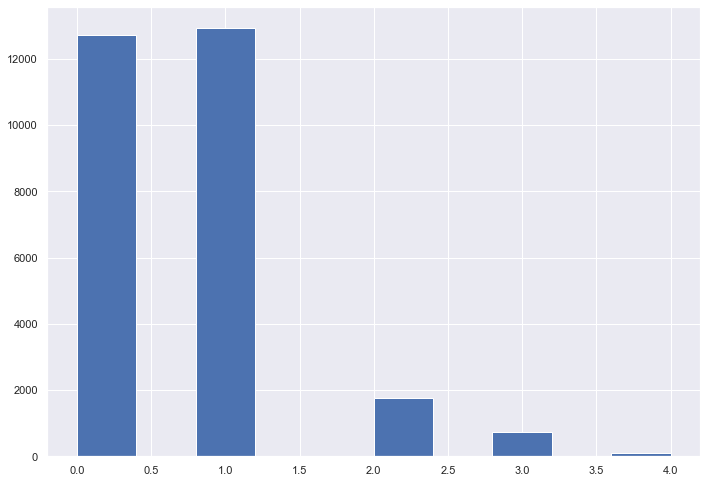

In [23]:
error = df.rounded_err.values
plt.hist(error);

Text(0, 0.5, 'Count')

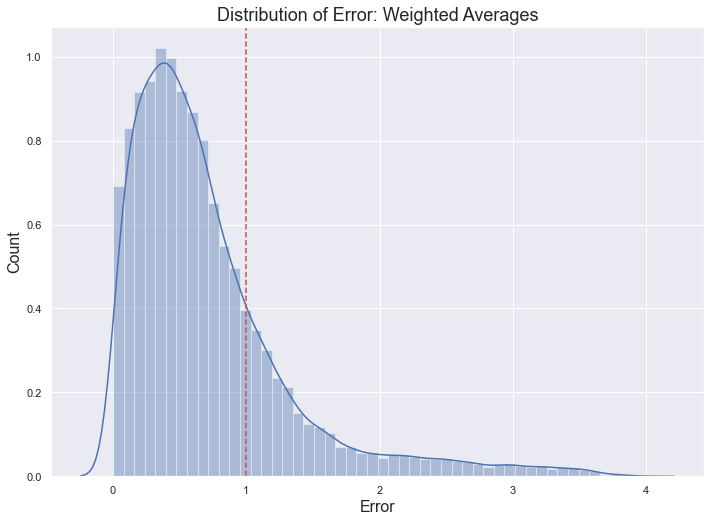

In [21]:
figure = sns.distplot(df.err, kde=True)
plt.axvline(np.median(error),color='r', linestyle='--')
plt.title('Distribution of Error: Weighted Averages', fontsize=18)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xlabel('Error', fontsize=16)
plt.ylabel('Count', fontsize=16)
# plt.savefig(r"../images/svd_error");

In [22]:
from surprise.model_selection import KFold


def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls



kf = KFold(n_splits=5)
algo = SVD(n_factors=10, n_epochs=80, lr_all=0.002, reg_all=0.4)

for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)

    # Precision and recall can then be averaged over all users
    print(sum(prec for prec in precisions.values()) / len(precisions))
    print(sum(rec for rec in recalls.values()) / len(recalls))

0.7739093575290991
0.7417506807724228
0.7710721868365182
0.7305213348611287
0.760565968393973
0.7303130073294746
0.7686221669430626
0.7344992288532434
0.7656821963394347
0.7324396024434504
